In [1]:
# if you want the new models you need to update pytorch and torchvision

In [16]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt

import pickle
import time
import os
import copy
import sys

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
print(device)
print(sys.version)
print(torch.__version__)
print(torchvision.__version__)

cpu
3.8.13 (default, Mar 28 2022, 11:38:47) 
[GCC 7.5.0]
1.12.1
0.13.1


In [4]:
from torchvision.models import vgg16_bn, VGG16_BN_Weights # just for test
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights
from torchvision.models import regnet_x_8gf, RegNet_X_8GF_Weights
from torchvision.models import swin_t, Swin_T_Weights
from torchvision.models import wide_resnet50_2, Wide_ResNet50_2_Weights

In [5]:
# from __future__ import print_function, division

# from torch.optim import lr_scheduler
# import torch.backends.cudnn as cudnn
# import matplotlib.pyplot as plt
# cudnn.benchmark = True
# plt.ion() 

In [6]:
#But you want the weights also

def get_models():

    weight_dict = {'convnext_tiny': ConvNeXt_Tiny_Weights.DEFAULT,
                'efficientnet_v2_s' : EfficientNet_V2_S_Weights.DEFAULT,
                'regnet_x_8gf' : RegNet_X_8GF_Weights.DEFAULT,
                'swin_t' : Swin_T_Weights.DEFAULT,
                'wide_resnet50_2' : Wide_ResNet50_2_Weights.DEFAULT}

    model_dict = {'convnext_tiny': convnext_tiny(weights = weight_dict['convnext_tiny']).to(device),
                'efficientnet_v2_s' : efficientnet_v2_s(weights = weight_dict['efficientnet_v2_s']).to(device),
                'regnet_x_8gf' : regnet_x_8gf(weights = weight_dict['regnet_x_8gf']).to(device),
                'swin_t' : swin_t(weights = weight_dict['swin_t']).to(device),
                'wide_resnet50_2' : wide_resnet50_2(weights = weight_dict['wide_resnet50_2']).to(device)}

    return(weight_dict, model_dict)

In [7]:
weight_dict, model_dict = get_models()

# set all models to eval
for model in model_dict.keys():
    model_dict[model].eval()

In [8]:
# choose one model
# model_name = 'convnext_tiny' # last block is called "classifier" 
# model_name = 'efficientnet_v2_s' # last block is called "classifier" 
# model_name = 'regnet_x_8gf' # last block is called "fc" 
# model_name = 'swin_t'  # last block is called "head" 
model_name = 'wide_resnet50_2'  # last block is called "fc" 


weights = weight_dict[model_name]
model = model_dict[model_name]

# print the model architectures
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

In [9]:
# preproces and data aug
data_transforms = {
'train': transforms.Compose([weights.transforms(), transforms.RandomHorizontalFlip()]), 
'val': transforms.Compose([weights.transforms()])
}

In [10]:
# Load data - a lot needs to change here since you have a score for each image and not a class (given by dir)

data_dir = '/home/simon/Documents/Bodies/data/RA/Tutorial/hymenoptera_data'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

batch_size = 4
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
num_classes = len(class_names)

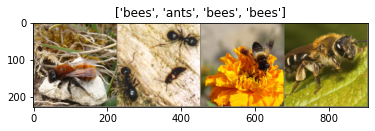

In [11]:
# Viz some images

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [12]:
# change last layer

def change_head(model_name, model, num_classes):

    if model_name == 'convnext_tiny':
        model.classifier[2] = nn.Linear(model.classifier[2].in_features, num_classes).to(device)
        print(f'new head: {model.classifier[2]}')

    elif model_name == 'efficientnet_v2_s':
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes).to(device)
        print(f'new head: {model.classifier[1]}')

    elif model_name == 'regnet_x_8gf':
        model.fc = nn.Linear(model.fc.in_features, num_classes).to(device)
        print(f'new head: {model.fc}')

    elif model_name == 'swin_t':
        model.head = nn.Linear(model.head.in_features, num_classes).to(device)
        print(f'new head: {model.head}')

    elif model_name == 'wide_resnet50_2':
        model.fc = nn.Linear(model.fc.in_features, num_classes).to(device)
        print(f'new head: {model.fc}')

    else:
        print('Unddefined model name...')


In [13]:
# choose one model
model_name = 'convnext_tiny' # last block is called "classifier" 
# model_name = 'efficientnet_v2_s' # last block is called "classifier" 
# model_name = 'regnet_x_8gf' # last block is called "fc" 
# model_name = 'swin_t'  # last block is called "head" 
# model_name = 'wide_resnet50_2'  # last block is called "fc" 

model = model_dict[model_name]
change_head(model_name, model, num_classes)


new head: Linear(in_features=768, out_features=2, bias=True)


In [15]:
# re-train all parameters
for param in list(model.parameters()):
  param.requires_grad = True

In [17]:
lr = 0.001
momentum = 0.9
# decay and so on...

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr) # they use AdamW in the convnext paper as one of their improvment

In [27]:
# set the model to train mode
model.train()

n_epochs = 4

for epoch in range(n_epochs):  # loop over the dataset multiple times

    history_loss = []
    running_loss = 0.0
    for i, data in enumerate(dataloaders['train'], 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = model(inputs)

        # loss + backward
        loss = criterion(outputs, labels)
        loss.backward()
        
        # optimize
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        history_loss.append(running_loss / dataset_sizes['train'])
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

Finished Training


In [ ]:
# you want to save the model
# and you need to be way more consistent with naming
# and you need to check wheter the output corrospond to the right classes - right now it just predicts (mostly) ants..

In [108]:
dataiter_test = iter(dataloaders['val'])
images_test, labels_test = dataiter_test.next()
images_test = images_test.to(device)
labels_test = labels_test.to(device)

outputs = model(images_test)
_, predicted = torch.max(outputs, 1)

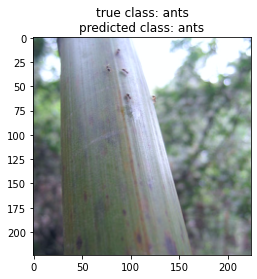

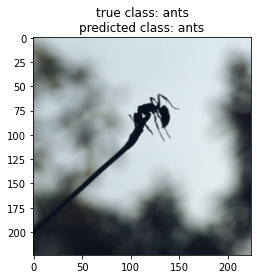

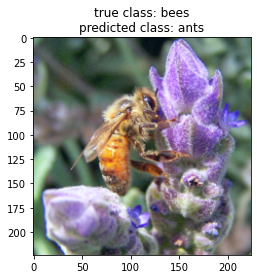

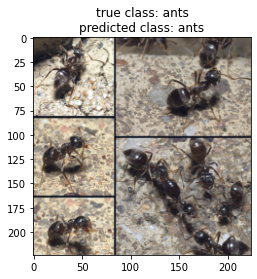

In [109]:

for i, j in enumerate(images_test):

    mean = 0.5
    std = 0.225
    img = np.clip(std * images_test[i].cpu().numpy().transpose((1,2,0)) + mean, 0, 1) # un norm and clip if ness


    plt.title(f'true class: {class_names[labels_test[i]]}\npredicted class: {class_names[predicted[i]]}')
    plt.imshow(img)
    plt.show()

In [88]:
(0.225 * img + 0.5).min()

0.042736977

In [81]:
np.random.rand(1000000).std()

0.2885312315309064

In [ ]:
    plt.figure(figsize=(10,8))
    
    for i in range(n):
      plt.subplot(1,n,i+1)
    
      img = images[i] #/ 2 + 0.5 # one image from batch and unnormalize      

      inp = img.cpu().numpy() #.transpose((1, 2, 0))
      mean = np.array([0.485, 0.456, 0.406])
      std = np.array([0.229, 0.224, 0.225])
      inp = std * inp + mean
      inp = np.clip(inp, 0, 1)
      
      plt.imshow(inp)
      plt.title(f'true class: {classes[labels[i]]}\npredicted class: {classes[predicted[i]]}')
    plt.show()

In [57]:
images_test.shape

torch.Size([4, 3, 224, 224])

In [59]:
# Make a grid from batch
out = torchvision.utils.make_grid(images_test)
imshow(inputs, title=[labels_test[x] for x in classes])

ValueError: axes don't match array

In [55]:
outputs

tensor([[ 0.0420, -0.0998],
        [ 0.0427, -0.0977],
        [ 0.0466, -0.1054],
        [ 0.0645, -0.1342]], grad_fn=<AddmmBackward0>)

In [40]:
img = images_test[0] 

In [48]:
(img * 0.229 + 0.4).max()

tensor(1.0046)

ValueError: operands could not be broadcast together with shapes (3,) (3,224,224) 

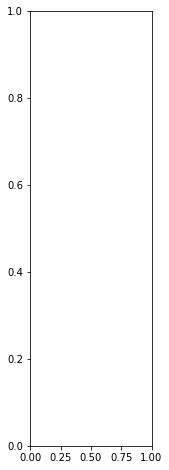

In [38]:


def show_predictions(images = images_test, labels = labels_test, classes = classes, predicted = predicted, n = 4):

    plt.figure(figsize=(10,8))
    
    for i in range(n):
      plt.subplot(1,n,i+1)
    
      img = images[i] #/ 2 + 0.5 # one image from batch and unnormalize      

      inp = img.cpu().numpy() #.transpose((1, 2, 0))
      mean = np.array([0.485, 0.456, 0.406])
      std = np.array([0.229, 0.224, 0.225])
      inp = std * inp + mean
      inp = np.clip(inp, 0, 1)
      
      plt.imshow(inp)
      plt.title(f'true class: {classes[labels[i]]}\npredicted class: {classes[predicted[i]]}')
    plt.show()

# show images
show_predictions(images = images_test, labels = labels_test)

In [29]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in dataloaders['val']:
        images, labels = data

        # if you run on gpu
        images = images.to(device)
        labels = labels.to(device)
        
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the val images: {100 * correct // total} %')

Accuracy of the network on the val images: 45 %


Linear(in_features=768, out_features=2, bias=True)


In [11]:
# Step 4: Use the model and print the predicted category (same images as the viz'ed)

for i in inputs:
   img = i.unsqueeze(0)

   prediction = model(img).squeeze(0).softmax(0)
   class_id = prediction.argmax().item()
   score = prediction[class_id].item()
   category_name = weights.meta["categories"][class_id]
   print(f"{category_name}: {100 * score:.1f}%")

ant: 65.1%
ant: 88.1%
bee: 67.7%
ant: 83.7%


In [ ]:
# load the model

# just for test
from torchvision.models import vgg16_bn, VGG16_BN_Weights # bn is simply the version with batch normalization

# remember weights now
# to use. All have relative few parameters. One is an transformer (swin) the rest is cnns
#from torchvision.models import convnext_tiny, efficientnet_v2_s, regnet_x_8gf, swin_t, wide_resnet50_2


In [ ]:
# depreciated
#model = vgg16_bn(pretrained = True).to(device)

# new api
weights = VGG16_BN_Weights.DEFAULT
model = vgg16_bn(weights = weights).to(device)
model.eval() # just for checking now


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
# Step 2: Initialize the inference transforms
preprocess = weights.transforms()

# Step 3: Apply inference preprocessing transforms
batch = preprocess(inputs).unsqueeze(0)

In [ ]:
# data_transforms = {
#     'train': transforms.Compose([
#         transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
#     'val': transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
# }

In [ ]:
# Step 4: Use the model and print the predicted category
prediction = model(batch).squeeze(0).softmax(0)
class_id = prediction.argmax().item()
score = prediction[class_id].item()
category_name = weights.meta["categories"][class_id]
print(f"{category_name}: {100 * score:.1f}%")

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1, 4, 3, 224, 224]

In [30]:
batch.shape

torch.Size([1, 4, 3, 224, 224])

In [25]:
transforms.RandomHorizontalFlip()

RandomHorizontalFlip(p=0.5)

In [24]:
batch

tensor([[[[[ 0.2918, -0.4557, -0.8913,  ...,  0.7621,  0.4527,  0.4489],
           [-0.2828, -0.8045, -1.3400,  ...,  0.6549,  0.3996,  0.4527],
           [-0.8723, -1.3364, -1.6852,  ...,  0.5798,  0.3368,  0.4022],
           ...,
           [-5.7660, -5.8928, -5.7675,  ...,  1.2642,  1.2666,  1.3448],
           [-4.1907, -4.9332, -5.4094,  ...,  1.2666,  1.2449,  1.3285],
           [-1.4404, -1.9388, -3.2483,  ...,  1.3463,  1.3323,  1.2715]],

          [[ 3.9943,  2.6342,  1.6151,  ...,  3.2717,  2.9191,  2.7881],
           [ 2.8177,  1.7153,  0.9114,  ...,  3.1596,  2.8516,  2.7286],
           [ 1.5409,  0.8949,  0.5240,  ...,  3.1181,  2.7933,  2.7115],
           ...,
           [-3.7187, -3.6891, -3.2345,  ...,  3.2494,  3.2518,  3.3337],
           [-2.2048, -2.9054, -3.1936,  ...,  3.2518,  3.2292,  3.3166],
           [ 0.1149, -0.3504, -1.6055,  ...,  3.3352,  3.3205,  3.2570]],

          [[-9.6345, -7.6931, -5.6394,  ..., -1.5614, -2.4119, -2.8528],
           [-8.

In [10]:
# print the model architectures
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [15]:
# specific for the arthitecture.
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes).to(device)

# now instead of 1000 out features we just have 2
# et will be the number of attributes when you get to that
print(model.classifier[6])

Linear(in_features=4096, out_features=2, bias=True)


In [18]:
VGG16_BN_Weights.DEFAULT.transforms()

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
VGG16_BN_Weights.IMAGENET1K_V1.transforms

In [ ]:
# data agumentation and resize
# likely also architecture specific

# data_transforms = {
#     'train': transforms.Compose([
#         transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
#     'val': transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
# }

In [ ]:
from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights

img = read_image("test/assets/encode_jpeg/grace_hopper_517x606.jpg")

# Step 1: Initialize model with the best available weights
model = resnet50(weights=weights)
model.eval()

# Step 2: Initialize the inference transforms
preprocess = weights.transforms()

# Step 3: Apply inference preprocessing transforms
batch = preprocess(img).unsqueeze(0)

# Step 4: Use the model and print the predicted category
prediction = model(batch).squeeze(0).softmax(0)
class_id = prediction.argmax().item()
score = prediction[class_id].item()
category_name = weights.meta["categories"][class_id]
print(f"{category_name}: {100 * score:.1f}%")